In [ ]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_ibm_runtime.fake_provider import FakeHanoiV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
from utils import *
from teleport import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

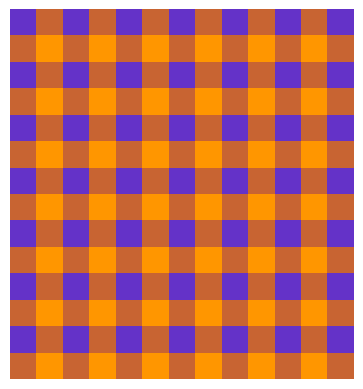

In [ ]:
"""R = np.array([
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200],
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200],
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200],
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200],
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200],
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200],
[100,200,100,200,100,200,100,200,100,200,100,200,100],
[200,255,200,255,200,255,200,255,200,255,200,255,200]
], dtype=np.uint8)



G = np.array([
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100],
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100],
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100],
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100],
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100],
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100],
[50,100,50,100,50,100,50,100,50,100,50,100,50],
[100,150,100,150,100,150,100,150,100,150,100,150,100]
], dtype=np.uint8)



B = np.array([
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
[200,50,200,50,200,50,200,50,200,50,200,50,200],
[50,0,50,0,50,0,50,0,50,0,50,0,50],
], dtype=np.uint8)

import numpy as np
import matplotlib.pyplot as plt

# Paste R, G, B here

rgb_image = np.stack((R, G, B), axis=-1)

plt.imshow(rgb_image)
plt.axis('off')
plt.show()

"""

In [41]:
import os
from PIL import Image
import numpy as np

folder_path = "images"  # your folder
file_name = "qc_img.JPG"  # exact filename

# Build full path
file_path = os.path.join(folder_path, file_name)

# Load image
img = Image.open(file_path).convert("RGB")
rgb_image = np.array(img)

# Split channels
R = rgb_image[:, :, 0]
G = rgb_image[:, :, 1]
B = rgb_image[:, :, 2]

print("Loaded:", file_path)
print("R shape:", R.shape, "G shape:", G.shape, "B shape:", B.shape)


Loaded: images\qc_img.JPG
R shape: (1136, 744) G shape: (1136, 744) B shape: (1136, 744)


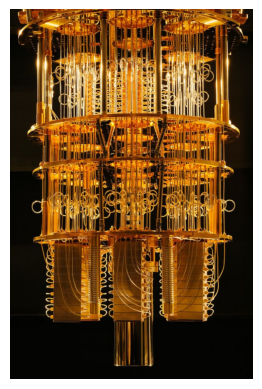

In [42]:
import matplotlib.pyplot as plt

#rotated = np.rot90(rgb_image, k=1)  # k=1 → 90° counterclockwise, k=3 → 90° clockwise
#plt.imshow(rotated)
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

In [43]:
l = R.shape[0]
w = R.shape[1]
m = l * w
l, w, m

(1136, 744, 845184)

In [44]:
n = int(math.log2(3 * l * w))
n

21

In [45]:
import numpy as np

real_img = np.zeros((2**n,), dtype=int)
im_img   = np.zeros((2**n,), dtype=int)

# Flatten RGB channels
R = rgb_image[:, :, 0].ravel()
G = rgb_image[:, :, 1].ravel()
B = rgb_image[:, :, 2].ravel()

# First m values
real_img[:m] = R
im_img[:m]   = B

# Alternate green channel values
real_img[m:m + (m+1)//2] = G[::2]  # green values at even indices → real
im_img[m:m + m//2]       = G[1::2] # green values at odd indices → imag

# Reshape to (2**n, 1) if needed
real_img = real_img.reshape(-1, 1)
im_img   = im_img.reshape(-1, 1)


In [49]:
img_vec = real_img + 1j * im_img

vec = img_vec.flatten()
vec = vec.astype(np.complex128)
psi_img = vec / np.linalg.norm(vec)

psi_img, vec

(array([0.00012235+3.3985408e-05j, 0.00012235+3.3985408e-05j,
        0.00012235+3.3985408e-05j, ..., 0.        +0.0000000e+00j,
        0.        +0.0000000e+00j, 0.        +0.0000000e+00j]),
 array([18.+5.j, 18.+5.j, 18.+5.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]))

In [50]:
psi_img.shape

(2097152,)

In [51]:
psi_sv = Statevector(psi_img)

In [52]:
#Prepare state to teleport

qca, ca = teleportation_circuit(n, psi_sv)
qca.draw('mpl')

MemoryError: In RendererAgg: Out of memory

<Figure size 2228.98x26287.3 with 1 Axes>

In [32]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Example: suppose qubits 0..21 are fixed to |0⟩
active_qubits = list(range(22, 43))  # adjust based on your fixed_qubits_map

# Create reduced circuit with only active qubits
reduced_qc = QuantumCircuit(len(active_qubits))

for instr, qargs, cargs in qca.data:
    # Map from Qubit object to its original index
    q_indices = [qca.find_bit(q)[0] for q in qargs]

    # Keep only gates that act entirely on active qubits
    if all(q in active_qubits for q in q_indices):
        mapped_qargs = [reduced_qc.qubits[active_qubits.index(q)] for q in q_indices]
        reduced_qc.append(instr, mapped_qargs, cargs)

# Simulate reduced circuit
sv_reduced = Statevector.from_instruction(reduced_qc)

print(sv_reduced)


C:\Users\saipr\AppData\Local\Temp\ipykernel_6924\3476226505.py:10: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qca.data:


Statevector([1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [33]:
len(sv_reduced)

2097152

In [34]:
"""sva = Statevector.from_instruction(qca)
sv_sent = extract_state(sva)
print(sv_sent)

sv_sent = sv_sent * np.linalg.norm(vec)
sv_sent"""

sv_sent = sv_reduced * np.linalg.norm(vec)
sv_sent

Statevector([337462.84166557+0.j,      0.        +0.j,      0.        +0.j,
             ...,      0.        +0.j,      0.        +0.j,
                  0.        +0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [35]:
R_sent = list(real_img[:m].ravel())
B_sent = list(im_img[:m].ravel())

# Extract green from alternating positions
green_even = real_img[m:m + (m+1)//2].ravel()
green_odd  = im_img[m:m + m//2].ravel()

# Interleave them back into full green array
G_sent = np.empty(m, dtype=int)
G_sent[::2] = green_even
G_sent[1::2] = green_odd

R_sent, G_sent.tolist(), B_sent


([np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(200),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201),
  np.int64(201

In [36]:
R_ = np.array(R_sent, dtype = np.uint8).reshape(l, w)
G_ = np.array(G_sent, dtype = np.uint8).reshape(l, w)
B_ = np.array(B_sent, dtype = np.uint8).reshape(l, w)
R_, G_, B_

(array([[200, 200, 200, ..., 201, 201, 201],
        [200, 200, 200, ..., 201, 201, 201],
        [200, 200, 200, ..., 201, 201, 201],
        ...,
        [ 97,  98,  99, ...,  88,  87,  85],
        [ 97,  97,  98, ...,  90,  90,  89],
        [100,  99,  99, ...,  91,  92,  93]], dtype=uint8),
 array([[217, 217, 217, ..., 216, 216, 216],
        [217, 217, 217, ..., 216, 216, 216],
        [217, 217, 217, ..., 216, 216, 216],
        ...,
        [ 94,  95,  94, ...,  89,  88,  86],
        [ 94,  94,  93, ...,  91,  91,  90],
        [ 97,  96,  94, ...,  92,  93,  94]], dtype=uint8),
 array([[235, 235, 235, ..., 235, 235, 235],
        [235, 235, 235, ..., 235, 235, 235],
        [235, 235, 235, ..., 235, 235, 235],
        ...,
        [ 89,  90,  90, ...,  91,  92,  90],
        [ 89,  89,  89, ...,  93,  95,  94],
        [ 92,  91,  90, ...,  94,  97,  98]], dtype=uint8))

In [53]:
rgb_image_ = np.stack((R_, G_, B_), axis=-1)



plt.imshow(rgb_image_)
#rotated = np.rot90(rgb_image, k=1)  # k=1 → 90° counterclockwise, k=3 → 90° clockwise
#plt.imshow(rotated)
plt.axis('off')
plt.show()

In [54]:
R_ = R_.ravel()
G_ = G_.ravel()
B_ = B_.ravel()

In [55]:
np.array_equal(R, R_), np.array_equal(G, G_), np.array_equal(B, B_)


(False, False, False)

In [135]:
R,R_

(array([100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200,
        100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200,
        100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200,
        100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200,
        100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200,
        100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200, 255, 200,
        100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100, 200, 100,
        200, 255, 200, 255, 200, 255, 200, 255, 200